In [1]:
# Loading the required libraries
import warnings
warnings.filterwarnings('ignore')
import sys
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image

In [2]:
# Loading population data : Based on our assumption, the entire dataset is considered as population data
population_data= pd.read_csv(r"Dataset.csv")

In [3]:
population_data.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


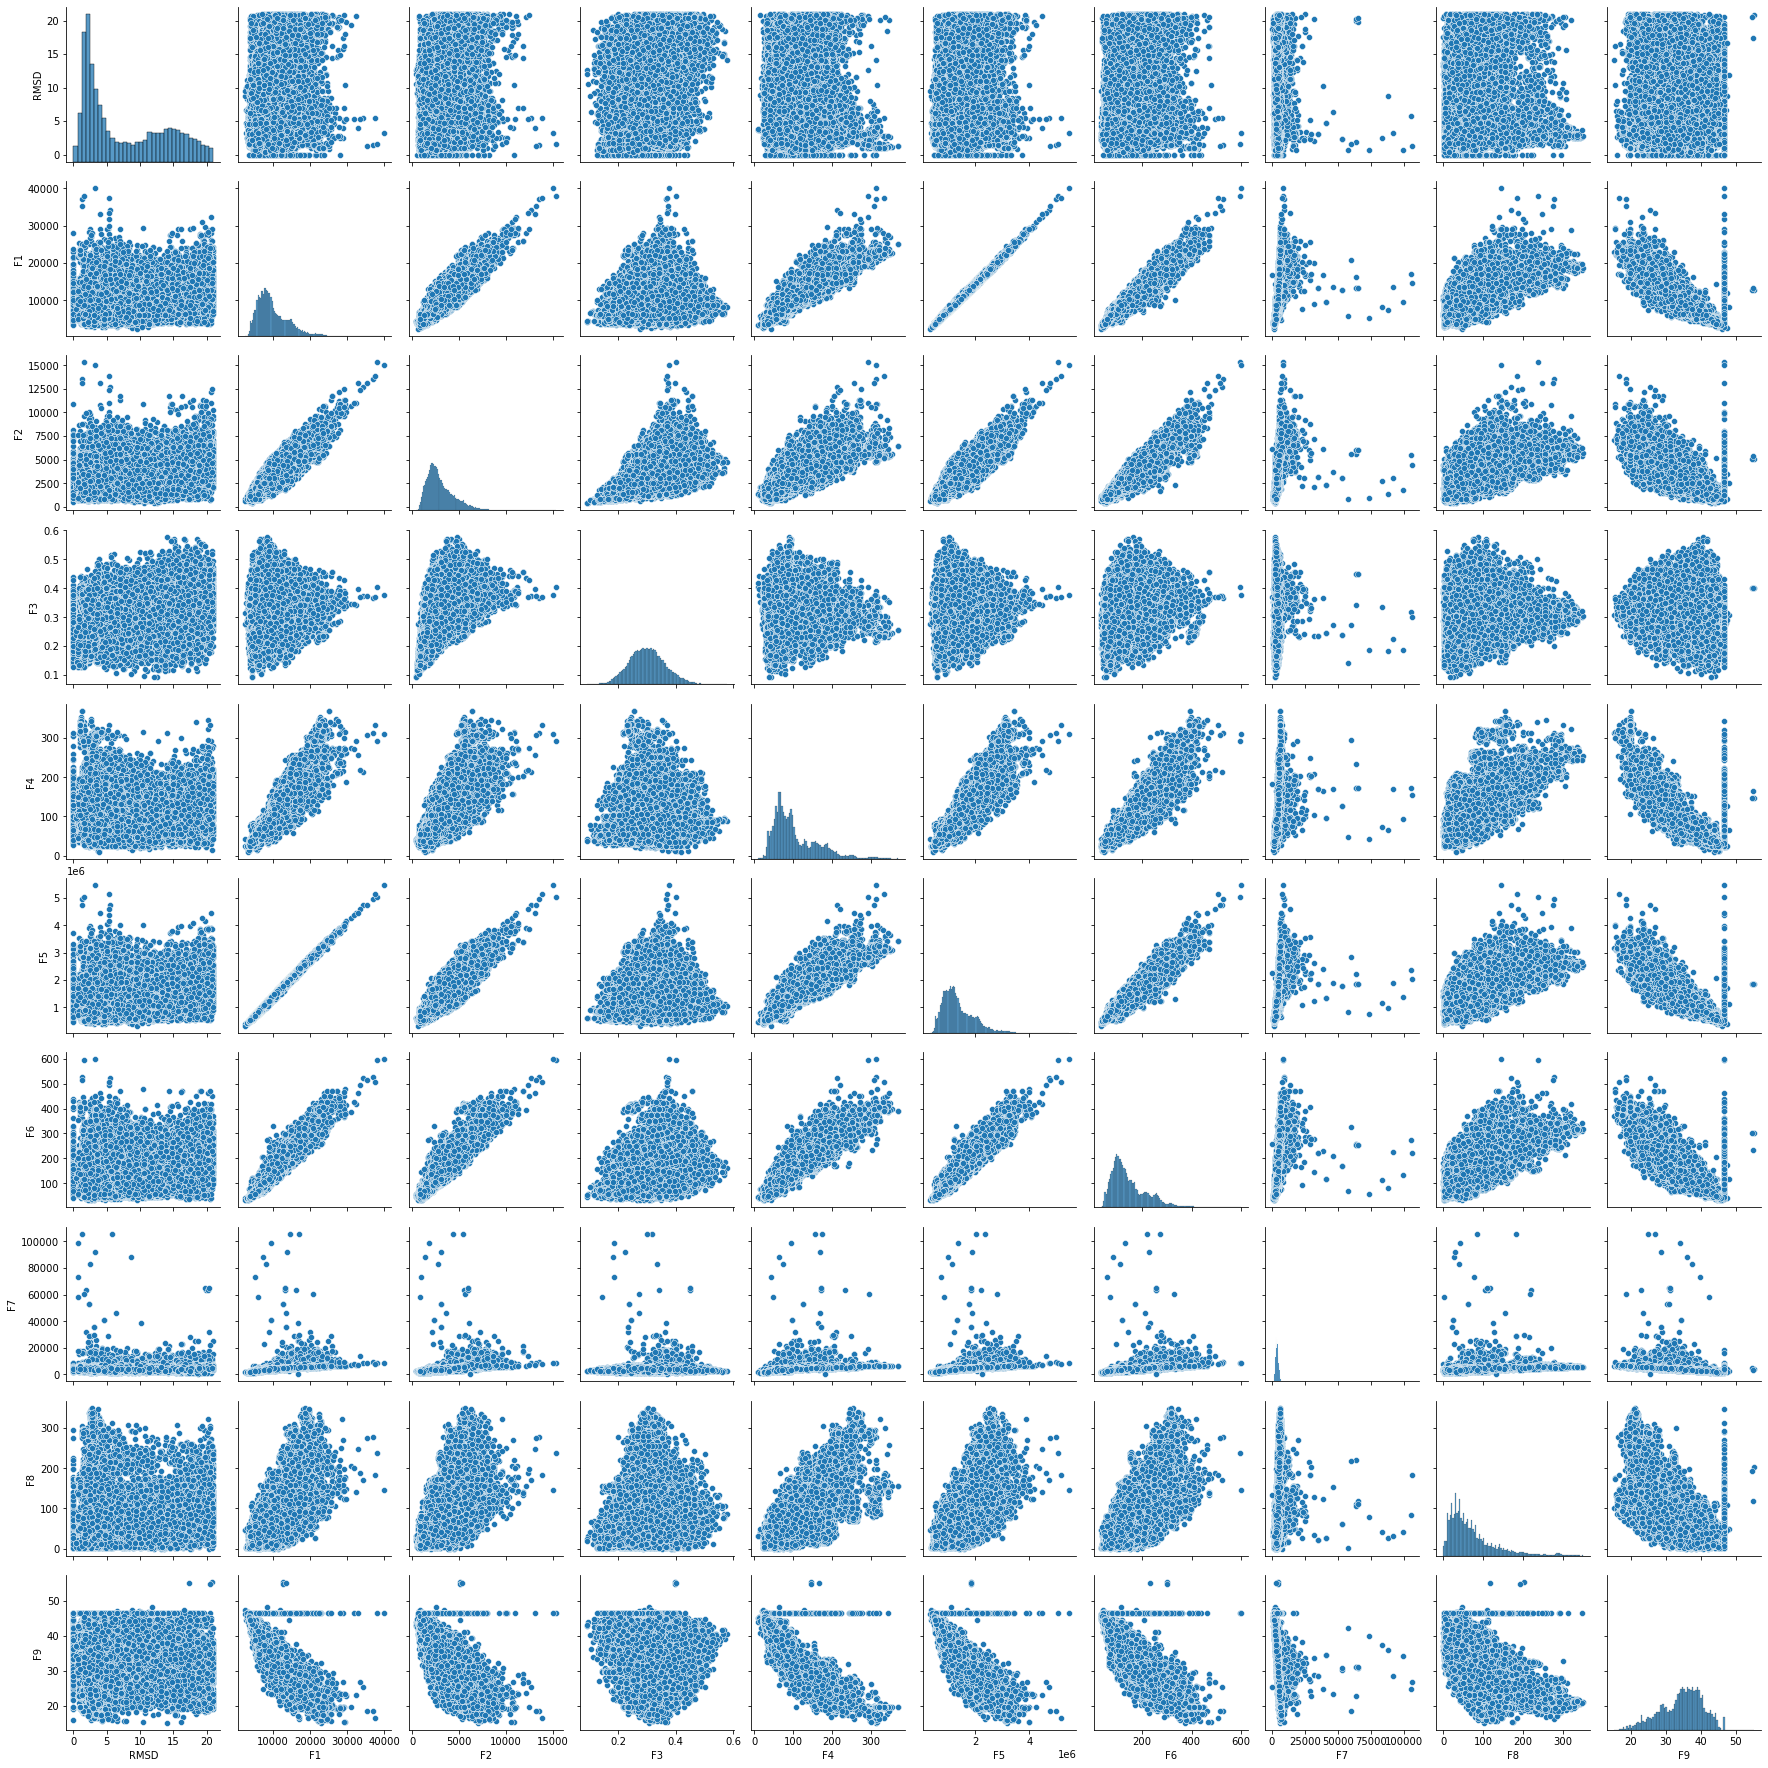

In [4]:
# Plotting the pair plot to get an idea of which variable could be considered as a target variable
sns.pairplot(population_data)

In [5]:
population_data.columns
# F9 is being considered as the dependent variable

Index(['RMSD', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9'], dtype='object')

In [6]:
population_data.shape
# so, our population has 45730 no of records

(45730, 10)

In [7]:
# Extracting the test data, on which the prediction is to be made and the corresponding variance 
# and bias calculation is made. No of records for test data - 300
test_data = population_data.sample(300, replace= False, random_state=100) 
# Test data should be part of the training data and reindexing it.
train_data = population_data.drop(test_data.index, axis=0).reindex()
# Reindexing the test data
test_data = test_data.reindex()

In [8]:
###################### Building population models ###############################################
# Separating the test and train variables
X_train = population_data.drop(['F9'], axis=1)
y_train = population_data['F9']
X_test = test_data.drop(['F9'], axis=1)
y_test = test_data['F9']

###################### Linear Regression #########################################################
# Note: The population data is inclusive of both test and train data
# Building a linear model on population data
population_linear_model = LinearRegression().fit(X_train, y_train)
y_hat_pop = population_linear_model.predict(X_test)

###################### Decision Tree #############################################################
# Building a Decision tree model on population data and obtaining predicion on test data
population_decision_tree = DecisionTreeRegressor(criterion='mse', min_samples_leaf=3).fit(X_train, y_train)
y_hat_pop_tree = population_decision_tree.predict(X_test)

###################### Bagging - Decision Tree ###################################################
# Building a Bagging model on population data and obtaining predicion on test data
population_bagging_model = BaggingRegressor().fit(X_train, y_train)
y_hat_pop_bagging = population_bagging_model.predict(X_test)


###################### Random Forest ###################################################
# Building a Random Forest model on population data and obtaining predicion on test data
population_randomForest_model = RandomForestRegressor().fit(X_train, y_train)
y_hat_pop_randomForest = population_randomForest_model.predict(X_test)

In [9]:
# Method to compute the variance
def calculate_varaince_of_model(samplePredictions, y_test):
    predictions_mean_model = samplePredictions.mean(axis =1)
    colNames = samplePredictions.columns
    variance = np.zeros(len(colNames))
    i = 0
    for colName in colNames:
        variance[i] = np.mean(np.square(samplePredictions[colName] - predictions_mean_model))
        rmse = mean_squared_error(y_test, samplePredictions[colName])
        i += 1
    return round(np.mean(variance),3), round(np.mean(rmse),3)

In [10]:
# Method to compute the bias
def calculate_bias_of_model(samplePredictions, y_hat_pop):
    return np.square((np.abs(samplePredictions.mean(axis=1) -y_hat_pop).mean()))

In [11]:
# Note : Care has to be taken such that X_test should be a value, as per the previous block of codes
# Method to build linear moodel, gives, predictions as an output.
def samplePredForLinearRegression(X_train, y_train):
    sample_Linear_Model = LinearRegression().fit(X_train, y_train)
    return sample_Linear_Model.predict(X_test)

# Method to build linear moodel
def samplePredForDecisionTree(X_train, y_train):
    sample_Tree_Model = DecisionTreeRegressor(criterion='mse', min_samples_leaf=3).fit(X_train, y_train)
    return sample_Tree_Model.predict(X_test)
    
# Method to build Decision tree bagging model
def samplePredForDTBaggin(X_train, y_train):
    sample_bagging_Model = BaggingRegressor().fit(X_train, y_train)
    return sample_bagging_Model.predict(X_test)

# Method to build Random Forst model
def samplePredForRandomForest(X_train, y_train):
    sample_RandomForest_Model = RandomForestRegressor().fit(X_train, y_train)
    return sample_RandomForest_Model.predict(X_test)

# Method to build Ridge Regression model
def samplePredForRidgeRegression(X_train, y_train, alpha):
    sample_ridge_model = Ridge(alpha=alpha, normalize=True)
    sample_ridge_model.fit(X_train,y_train)
    return sample_ridge_model.predict(X_test)

In [12]:
# it is the main method, which computes the bias and variance of various model
# Takes sampleCount - sample size and noOfModels - no of models that are to be built i.e. the no of times the samples are to
# be obtained from the population
def get_bias_variance(sampleCount, noOfModels):
    bias_variance_result = pd.DataFrame(columns=['sample_count','no_of_models','algorithm','bias','variance', 'mse'])
    print('Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms')
    print('Total No of models built is',str(noOfModels* 4))
    
    samplePredictionsLinearModel = pd.DataFrame()
    samplePredictionsTree = pd.DataFrame()
    samplePredictionsBagging = pd.DataFrame()
    samplePredictionsRandomForest = pd.DataFrame()
    
    with tqdm.tqdm(total=noOfModels, file=sys.stdout) as pbar:
        for i in range(0, noOfModels):
            pbar.set_description('Building Model : %d' % (1 + i))
            sample = train_data.sample(sampleCount,replace=False)
            X_train = sample.drop(['F9'], axis=1)
            y_train = sample['F9']

            samplePredictionsLinearModel['sample'+str(i+1)] = samplePredForLinearRegression(X_train, y_train)
            samplePredictionsTree['sample'+str(i+1)] = samplePredForDecisionTree(X_train, y_train)
            samplePredictionsBagging['sample'+str(i+1)] = samplePredForDTBaggin(X_train, y_train)
            samplePredictionsRandomForest['sample'+str(i+1)] = samplePredForRandomForest(X_train, y_train)
            pbar.update(1)
    
    '''print('samplePredictionsLinearModel :', samplePredictionsLinearModel.shape)
    print('samplePredictionsTree :', samplePredictionsTree.shape)
    print('samplePredictionsBagging :', samplePredictionsBagging.shape)
    print('samplePredictionsRandomForest :', samplePredictionsRandomForest.shape)'''
    
    var_mse_linear_model = calculate_varaince_of_model(samplePredictionsLinearModel, y_test)
    var_mse_tree_model = calculate_varaince_of_model(samplePredictionsTree, y_test)
    var_mse_bagging_model = calculate_varaince_of_model(samplePredictionsBagging, y_test)
    var_mse_random_forest_model = calculate_varaince_of_model(samplePredictionsRandomForest, y_test)
    
    bias_linear_model = calculate_bias_of_model(samplePredictionsLinearModel, y_hat_pop)
    bias_tree_model = calculate_bias_of_model(samplePredictionsTree, y_hat_pop_tree)
    bias_bagging_model = calculate_bias_of_model(samplePredictionsBagging, y_hat_pop_bagging)
    bias_random_forest_model = calculate_bias_of_model(samplePredictionsRandomForest, y_hat_pop_randomForest)
    
    s_linear = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'LR',
                    'bias':bias_linear_model, 'variance' : var_mse_linear_model[0], 'mse' : var_mse_linear_model[1]}, name = 0)
    
    s_tree = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'DecisionTree',
                    'bias':bias_tree_model, 'variance' : var_mse_tree_model[0], 'mse' : var_mse_tree_model[1]}, name = 0)
    
    s_bagging = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'Bagging',
                    'bias':bias_bagging_model, 'variance' : var_mse_bagging_model[0], 'mse' : var_mse_bagging_model[1]}, name = 0)
    
    s_rf = pd.Series(data={'sample_count':sampleCount, 'no_of_models':noOfModels, 'algorithm':'RandomForest',
                    'bias':bias_random_forest_model, 'variance' : var_mse_random_forest_model[0], 'mse' : var_mse_random_forest_model[1]}, name = 0)
    
    bias_variance_result = bias_variance_result.append(s_linear)
    bias_variance_result = bias_variance_result.append(s_tree)
    bias_variance_result = bias_variance_result.append(s_bagging)
    bias_variance_result = bias_variance_result.append(s_rf)
    
    bias_variance_result.reset_index(inplace=True)
    bias_variance_result.drop(['index'], axis=1, inplace=True)
    
    return bias_variance_result

In [13]:
# Computes variance and bias for a given sample count and for various predefined alpha values
def get_bias_variance_ridge_regression(sampleCount, noOfModels):
    bias_variance_result = pd.DataFrame(columns=['alpha','bias','variance', 'mse'])
    print('Ridge Regression')
    samplePredictionsRidge = pd.DataFrame()
    alphas = [0.01, 0.05,0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.40]
    
    for alpha in alphas:
        for i in range(0, noOfModels):
            sample = train_data.sample(sampleCount,replace=False)
            X_train = sample.drop(['F9'], axis=1)
            y_train = sample['F9']

            samplePredictionsRidge['sample'+str(i+1)] = samplePredForRidgeRegression(X_train, y_train, alpha)
        
        var_mse_ridge_model = calculate_varaince_of_model(samplePredictionsRidge, y_test)
        bias_ridge_model = calculate_bias_of_model(samplePredictionsRidge, y_hat_pop)
    
        s_linear = pd.Series(data={'alpha' : alpha, 'bias':bias_ridge_model, 
                               'variance' : var_mse_ridge_model[0], 'mse' : var_mse_ridge_model[1]}, name =0)
        
        bias_variance_result = bias_variance_result.append(s_linear)
    
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    
    ax[0].plot(bias_variance_result.alpha, bias_variance_result.bias)
    ax[0].plot(bias_variance_result.alpha, bias_variance_result.variance)
    ax[0].legend(['bias','variance'])
    ax[0].set_xlabel('alpha')
    
    ax[1].plot(bias_variance_result.alpha, bias_variance_result.mse)
    ax[1].legend(['mse'])
    ax[1].set_xlabel('alpha')
    plt.show()
    
    bias_variance_result.reset_index(inplace=True)
    bias_variance_result.drop(['index'], axis=1, inplace=True)
    
    return bias_variance_result

In [14]:
# Generating the bias and variance for various sample sizes
noOfSamples = [100,500,1000,2000,4000,8000,10000]
#noOfSamples = [100,300,500,700,900,1000,1200]
noOfModels = 20
lenNoOfSamples = len(noOfSamples)
bias_variance_result = pd.DataFrame()
print('Building Model for samples ', noOfSamples)
for i in range(0, lenNoOfSamples):
    noOfSample = noOfSamples[i]
    print('Building models with sample size : ', noOfSample)
    bias_variance_result = bias_variance_result.append(get_bias_variance(noOfSample,noOfModels))
bias_variance_result.reset_index(inplace=True)
bias_variance_result.drop(['index'], axis=1, inplace=True)

Building Model for samples  [100, 500, 1000, 2000, 4000, 8000, 10000]
Building models with sample size :  100
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [00:02<00:00,  7.02it/s]
Building models with sample size :  500
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]
Building models with sample size :  1000
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [00:09<00:00,  2.00it/s]
Building models with sample size :  2000
Builds Linear Regression, Decision Tree, Bagging, Random Forest algorithms
Total No of models built is 80
Building Model : 20: 100%|██████████| 20/20 [00:19<00:00,  1.01it/s]
Building models with sample size :  4000
Builds Linear Regression, D

In [15]:
bias_variance_result

,sample_count,no_of_models,algorithm,bias,variance,mse
0,100,20,LR,0.34061,2.035,8.37
1,100,20,DecisionTree,1.565012,4.079,11.13
2,100,20,Bagging,1.091951,1.839,6.727
3,100,20,RandomForest,1.013692,1.36,6.471
4,500,20,LR,0.033626,0.444,6.885
5,500,20,DecisionTree,1.129064,2.281,6.963
6,500,20,Bagging,0.825239,0.875,5.763
7,500,20,RandomForest,0.774077,0.582,5.654
8,1000,20,LR,0.032525,0.307,6.959
9,1000,20,DecisionTree,1.027141,2.371,6.62


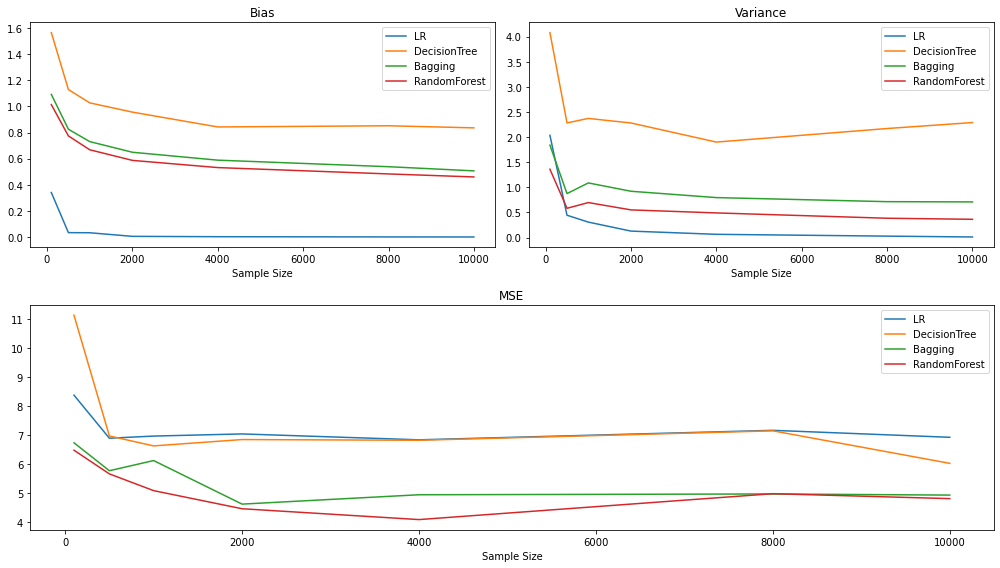

In [16]:
# Plotting the obtained results
fig = plt.figure(figsize=(14,8))
layout = (2, 2)

ax0 = plt.subplot2grid(layout, (0, 0))
ax0.title.set_text('Bias')

temp = bias_variance_result[bias_variance_result['algorithm'] == 'LR']
ax0.plot(temp.sample_count, temp.bias)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'DecisionTree']
ax0.plot(temp.sample_count, temp.bias)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Bagging']
ax0.plot(temp.sample_count, temp.bias)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'RandomForest']
ax0.plot(temp.sample_count, temp.bias)

ax0.legend(['LR','DecisionTree','Bagging','RandomForest'], loc=1)
ax0.set_xlabel('Sample Size')

ax1 = plt.subplot2grid(layout, (0, 1))
ax1.title.set_text('Variance')

temp = bias_variance_result[bias_variance_result['algorithm'] == 'LR']
ax1.plot(temp.sample_count, temp.variance)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'DecisionTree']
ax1.plot(temp.sample_count, temp.variance)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Bagging']
ax1.plot(temp.sample_count, temp.variance)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'RandomForest']
ax1.plot(temp.sample_count, temp.variance)

ax1.legend(['LR','DecisionTree','Bagging','RandomForest'], loc=1)
ax1.set_xlabel('Sample Size')


ax2 = plt.subplot2grid(layout, (1, 0), colspan=2)
ax2.title.set_text('MSE')

temp = bias_variance_result[bias_variance_result['algorithm'] == 'LR']
ax2.plot(temp.sample_count, temp.mse)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'DecisionTree']
ax2.plot(temp.sample_count, temp.mse)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'Bagging']
ax2.plot(temp.sample_count, temp.mse)

temp = bias_variance_result[bias_variance_result['algorithm'] == 'RandomForest']
ax2.plot(temp.sample_count, temp.mse)

ax2.legend(['LR','DecisionTree','Bagging','RandomForest'], loc=1)
ax2.set_xlabel('Sample Size')


plt.tight_layout()

In [17]:
bias_variance_result[bias_variance_result['sample_count'] == 8000]

,sample_count,no_of_models,algorithm,bias,variance,mse
20,8000,20,LR,0.00066,0.028,7.157
21,8000,20,DecisionTree,0.851844,2.17,7.14
22,8000,20,Bagging,0.538325,0.714,4.961
23,8000,20,RandomForest,0.483007,0.384,4.97


<AxesSubplot:xlabel='algorithm', ylabel='value'>

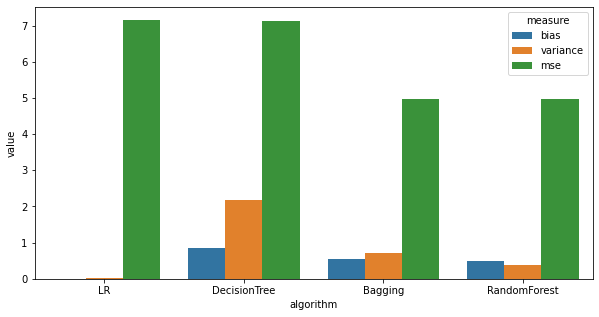

In [18]:
df = bias_variance_result[bias_variance_result['sample_count'] == 8000][['algorithm','bias','variance','mse']]

t = pd.DataFrame(columns=['algorithm', 'measure', 'value'])
for measure in ['bias','variance','mse']:
    values = df[measure].values
    algos = df['algorithm'].values
    for i in range (0,len(values)):
        t = t.append(pd.Series(data={'algorithm':algos[i],'measure':measure, 'value' : values[i]},name =0))

plt.figure(figsize=(10,5))
sns.barplot(x='algorithm', y='value', hue='measure', data=t)

Ridge Regression


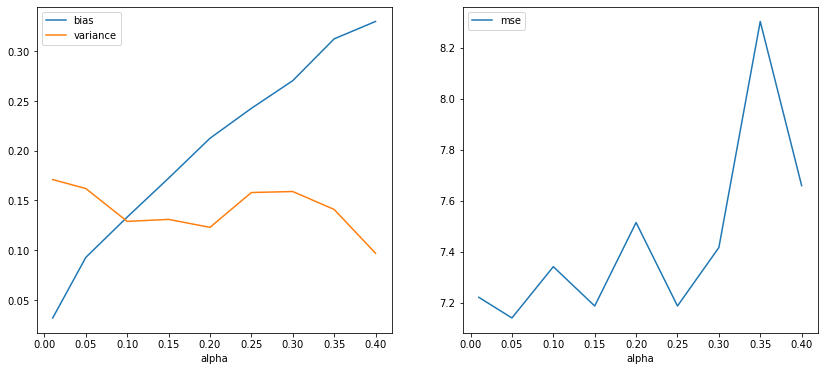

In [19]:
t = get_bias_variance_ridge_regression(1000, 30)

Ridge Regression


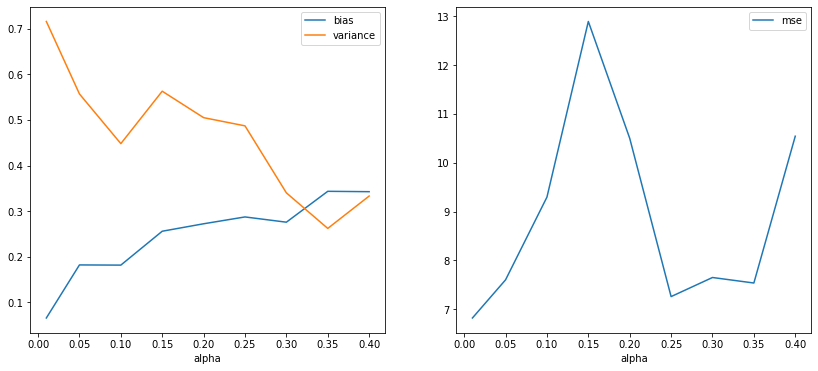

In [20]:
t = get_bias_variance_ridge_regression(300, 15)